# Datasets

In [2]:
# When running this tutorial in Google Colab, install the required packages
# with the following.
# !pip install torchaudio

import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

1.12.0+cpu
0.12.0+cpu


In [3]:
# @title Prepare data and utility functions. {display-mode: "form"}
# @markdown
# @markdown You do not need to look into this cell.
# @markdown Just execute once and you are good to go.

# -------------------------------------------------------------------------------
# Preparation of data and helper functions.
# -------------------------------------------------------------------------------
import multiprocessing
import os

import matplotlib.pyplot as plt
from IPython.display import Audio, display


_SAMPLE_DIR = "_assets"
YESNO_DATASET_PATH = os.path.join(_SAMPLE_DIR, "yes_no")
os.makedirs(YESNO_DATASET_PATH, exist_ok=True)


def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)


def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

  0%|          | 0.00/4.49M [00:00<?, ?B/s]

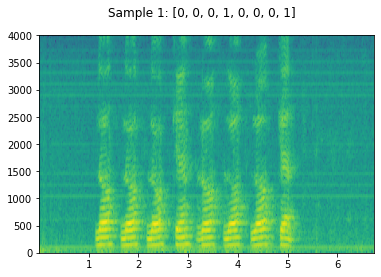

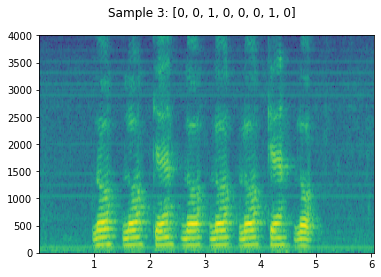

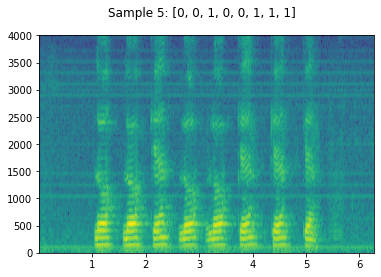

In [4]:
dataset = torchaudio.datasets.YESNO(YESNO_DATASET_PATH, download=True)

for i in [1, 3, 5]:
    waveform, sample_rate, label = dataset[i]
    plot_specgram(waveform, sample_rate, title=f"Sample {i}: {label}")
    play_audio(waveform, sample_rate)

# Speech Recognition

In [13]:
import os
import matplotlib.pyplot as plt
import matplotlib
import requests
import torch
import torchaudio
import IPython

In [7]:
matplotlib.rcParams["figure.figsize"] = [16.0, 4.8]
torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.__version__)
print(torchaudio.__version__)
print(device)

SPEECH_URL = "https://pytorch-tutorial-assets.s3.amazonaws.com/VOiCES_devkit/source-16k/train/sp0307/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav"  # noqa: E501
SPEECH_FILE = "_assets/speech.wav"

if not os.path.exists(SPEECH_FILE):
    os.makedirs("_assets", axit_ok=True)
    with open(SPEECH_FILE, "wb") as file:
        file.write(requests.get(SPEECH_URL).content)

1.12.0+cpu
0.12.0+cpu
cpu


In [9]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
print("Smaple Rate:", bundle.sample_rate)
print("Labels:", bundle.get_labels())

Smaple Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [11]:
model = bundle.get_model().to(device)
print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to C:\Users\jatin/.cache\torch\hub\checkpoints\wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


In [15]:
IPython.display.Audio(SPEECH_FILE)

In [16]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

In [18]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

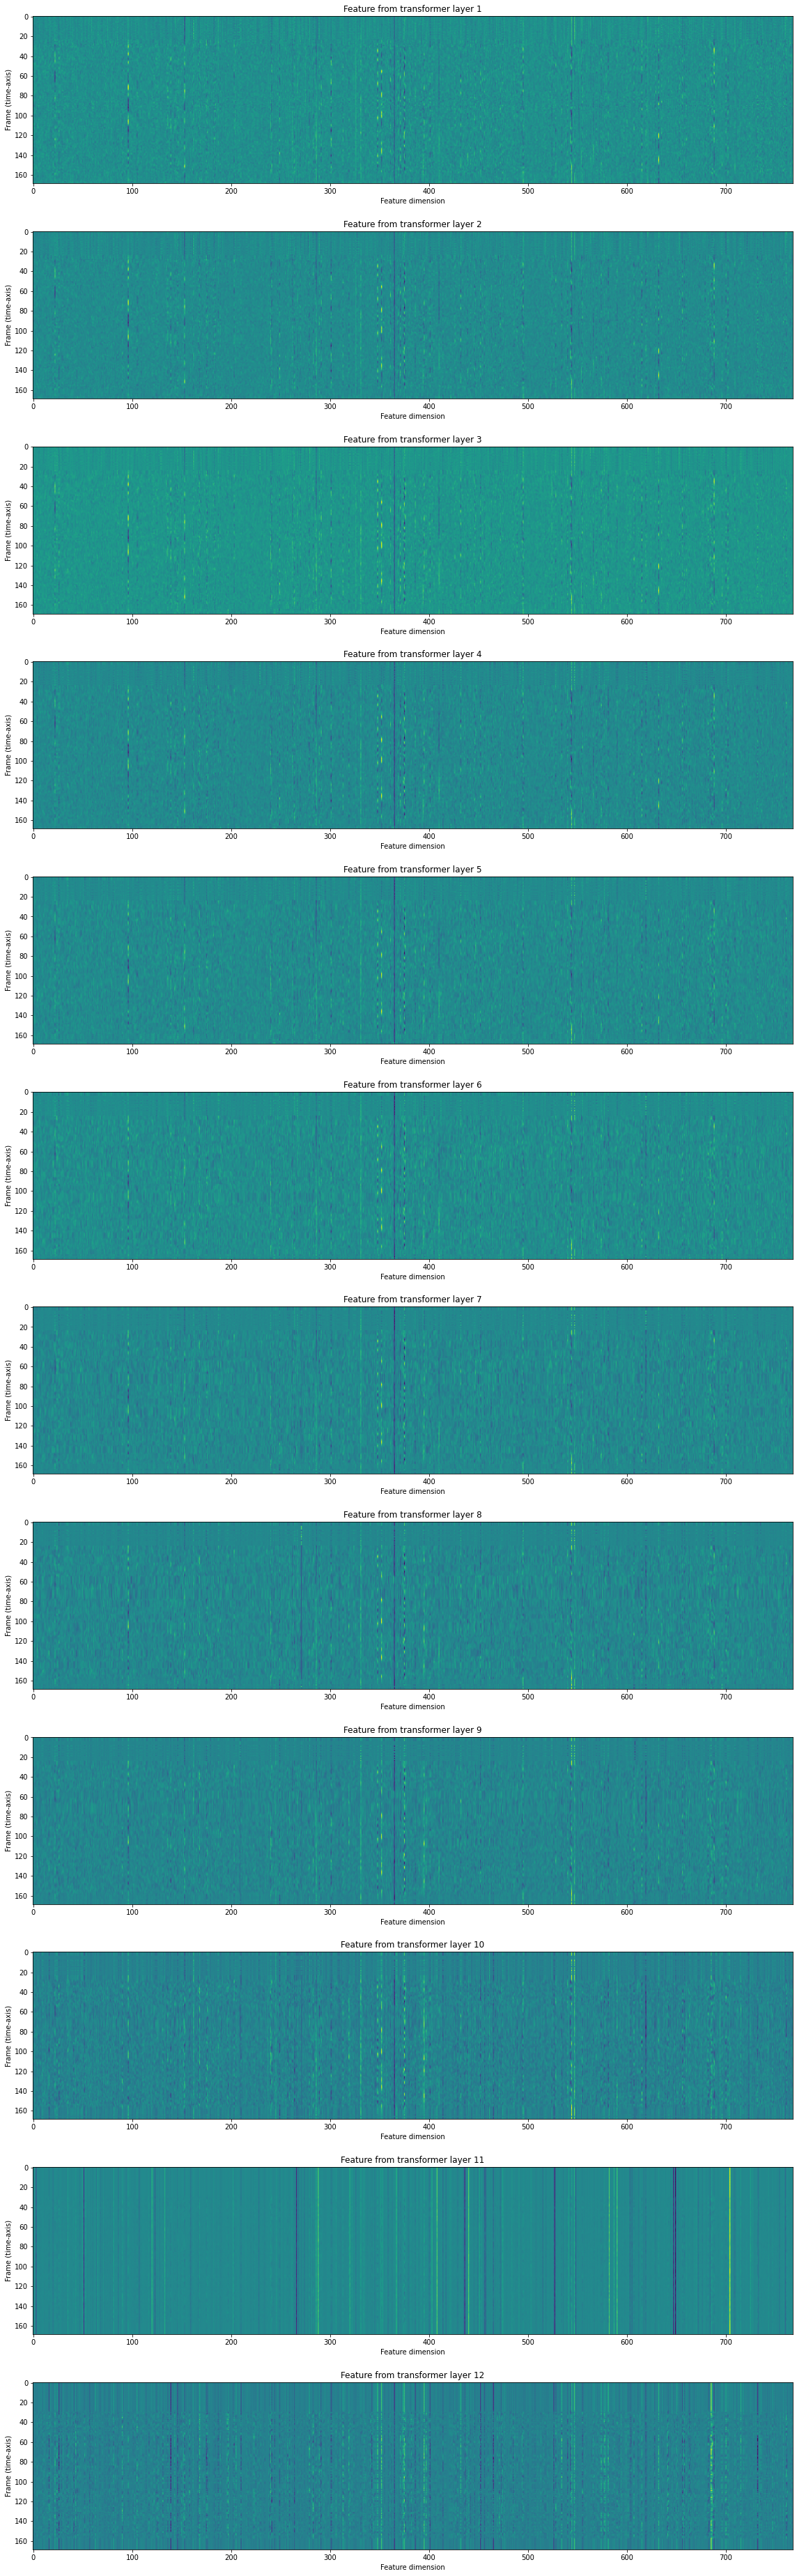

In [19]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu())
    ax[i].set_title(f"Feature from transformer layer {i + 1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

In [20]:
with torch.inference_mode():
    emission, _ = model(waveform)

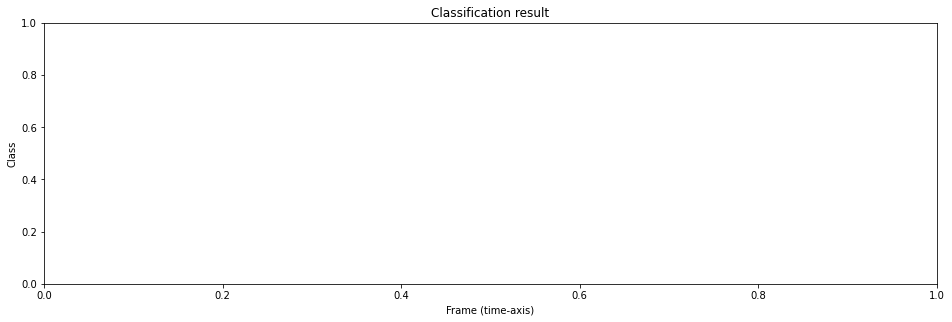

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [23]:
plt.title(emission[0].cpu().T)
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

In [24]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank
    def forward(self, emission: torch.Tensor)->str:
        indices = torch.argmax(emission, dim=-1)
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

In [25]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

In [26]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|


In [29]:
model = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.get_model()
emission = model(waveform)

# Speech Command Classification with torchaudio

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [34]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

Shape of waveform:torch.Size([1, 16000])
Sample rate of waveform: 16000


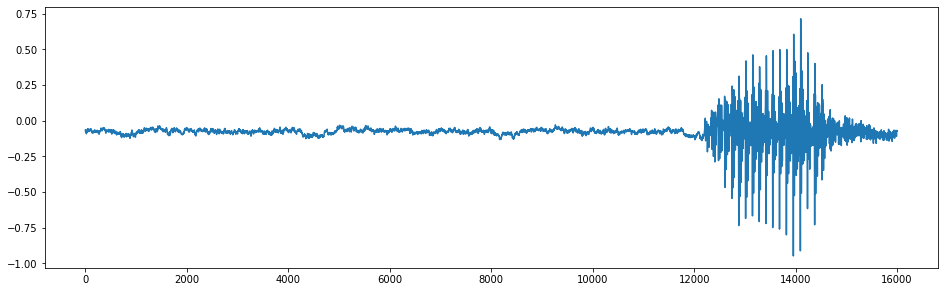

In [36]:
print("Shape of waveform:{}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))
plt.plot(waveform.t().numpy())

In [38]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

In [41]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

In [42]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [43]:
def label_to_index(word):
    return torch.tensor(labels.index(word))

def index_to_label(index):
    return labels[index]

word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


In [52]:
def pad_sequence(batch):
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

def collate_fn(batch):
    tensors, targets = [], []
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets
batch_size = 256
if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, 
                                          num_workers=num_workers, pin_memory=pin_memory)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, drop_last=False, 
                                         collate_fn=collate_fn, num_workers=num_workers, pin_memory=pin_memory)

In [58]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

In [59]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [60]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        
        data = transform(data)
        output = model(data)
        
        loss = F.nll_loss(output.squeeze(), target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)} / {len(train_loader.dataset)}] ({100.*batch_idx / len(train_loader):.0f}%\tLoss: {loss.item():.6f})")
        pbar.update(pbar_update)
        losses.append(loss.item())

In [61]:
def number_of_correct(pred, target):
    return pred.squeeze().eq(target).sum().item()

def get_likely_index(tensor):
    return tensor.argmax(dim=-1)

def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        
        data = transform(data)
        output = model(data)
        
        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)
        pbar.update(pbar_update)
    print(f"\nTest epoch: {epoch}\tAccuracy:{correct}/{len(test_loader.dataset)} ({100.*correct / len(test_loader.dataset):.0f}%)\n")

In [62]:
log_interval = 20
n_epoch = 2

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

  0%|          | 0.0026666666666666666/2 [00:01<24:25, 733.68s/it]

Train Epoch: 1 [0 / 84843] (0%	Loss: 3.815402)


  3%|▎         | 0.05599999999999999/2 [00:37<22:10, 684.43s/it]  

Train Epoch: 1 [5120 / 84843] (6%	Loss: 2.909338)


  5%|▌         | 0.10933333333333328/2 [01:16<23:07, 733.63s/it] 

Train Epoch: 1 [10240 / 84843] (12%	Loss: 2.574029)


  8%|▊         | 0.16266666666666676/2 [01:56<22:35, 737.70s/it]

Train Epoch: 1 [15360 / 84843] (18%	Loss: 2.341645)


 11%|█         | 0.21600000000000033/2 [02:39<23:35, 793.20s/it]

Train Epoch: 1 [20480 / 84843] (24%	Loss: 2.038487)


 13%|█▎        | 0.2693333333333337/2 [03:23<22:53, 793.87s/it] 

Train Epoch: 1 [25600 / 84843] (30%	Loss: 1.799322)


 16%|█▌        | 0.3226666666666667/2 [04:08<23:35, 844.10s/it] 

Train Epoch: 1 [30720 / 84843] (36%	Loss: 1.864443)


 19%|█▉        | 0.3759999999999997/2 [04:55<23:53, 882.74s/it] 

Train Epoch: 1 [35840 / 84843] (42%	Loss: 1.936869)


 21%|██▏       | 0.42933333333333273/2 [05:42<22:06, 844.76s/it]

Train Epoch: 1 [40960 / 84843] (48%	Loss: 1.533386)


 24%|██▍       | 0.48266666666666574/2 [06:31<23:18, 921.90s/it] 

Train Epoch: 1 [46080 / 84843] (54%	Loss: 1.688725)


 27%|██▋       | 0.5359999999999995/2 [07:19<22:10, 908.99s/it] 

Train Epoch: 1 [51200 / 84843] (60%	Loss: 1.388594)


 29%|██▉       | 0.5893333333333336/2 [08:09<22:31, 957.98s/it] 

Train Epoch: 1 [56320 / 84843] (66%	Loss: 1.623344)


 32%|███▏      | 0.6426666666666677/2 [08:59<19:44, 872.42s/it] 

Train Epoch: 1 [61440 / 84843] (72%	Loss: 1.429376)


 35%|███▍      | 0.6960000000000018/2 [09:49<21:31, 990.12s/it] 

Train Epoch: 1 [66560 / 84843] (78%	Loss: 1.208660)


 37%|███▋      | 0.749333333333336/2 [10:41<20:07, 965.62s/it]  

Train Epoch: 1 [71680 / 84843] (84%	Loss: 1.120598)


 40%|████      | 0.8026666666666701/2 [11:38<21:25, 1073.42s/it]

Train Epoch: 1 [76800 / 84843] (90%	Loss: 1.349553)


 43%|████▎     | 0.8560000000000042/2 [12:35<20:31, 1076.55s/it]

Train Epoch: 1 [81920 / 84843] (96%	Loss: 1.236812)


 50%|█████     | 1.0000000000000062/2 [15:07<17:46, 1066.76s/it]


Test epoch: 1	Accuracy:6239/11005 (57%)



 50%|█████     | 1.0026666666666728/2 [15:09<14:53, 895.74s/it] 

Train Epoch: 2 [0 / 84843] (0%	Loss: 1.116251)


 53%|█████▎    | 1.0560000000000047/2 [15:38<08:26, 536.38s/it]

Train Epoch: 2 [5120 / 84843] (6%	Loss: 1.152179)


 55%|█████▌    | 1.1093333333333366/2 [16:09<08:48, 593.28s/it]

Train Epoch: 2 [10240 / 84843] (12%	Loss: 1.034248)


 58%|█████▊    | 1.1626666666666685/2 [16:37<07:45, 555.97s/it]

Train Epoch: 2 [15360 / 84843] (18%	Loss: 1.145736)


 61%|██████    | 1.2160000000000004/2 [17:09<08:01, 613.83s/it]

Train Epoch: 2 [20480 / 84843] (24%	Loss: 1.077451)


 63%|██████▎   | 1.2693333333333323/2 [17:39<06:45, 554.49s/it]

Train Epoch: 2 [25600 / 84843] (30%	Loss: 1.061851)


 66%|██████▌   | 1.3226666666666642/2 [18:13<07:10, 634.85s/it]

Train Epoch: 2 [30720 / 84843] (36%	Loss: 1.100884)


 69%|██████▉   | 1.3759999999999961/2 [18:48<06:59, 672.56s/it]

Train Epoch: 2 [35840 / 84843] (42%	Loss: 1.244418)


 71%|███████▏  | 1.429333333333328/2 [19:26<07:51, 825.68s/it] 

Train Epoch: 2 [40960 / 84843] (48%	Loss: 0.910013)


 74%|███████▍  | 1.48266666666666/2 [20:05<06:45, 783.96s/it]  

Train Epoch: 2 [46080 / 84843] (54%	Loss: 0.850620)


 77%|███████▋  | 1.5359999999999918/2 [20:49<06:58, 902.92s/it]

Train Epoch: 2 [51200 / 84843] (60%	Loss: 1.061669)


 79%|███████▉  | 1.5893333333333237/2 [21:39<06:31, 952.41s/it] 

Train Epoch: 2 [56320 / 84843] (66%	Loss: 1.079859)


 82%|████████▏ | 1.6426666666666556/2 [22:33<06:17, 1057.15s/it]

Train Epoch: 2 [61440 / 84843] (72%	Loss: 0.971942)


 85%|████████▍ | 1.6959999999999875/2 [23:31<05:22, 1061.71s/it]

Train Epoch: 2 [66560 / 84843] (78%	Loss: 0.989576)


 87%|████████▋ | 1.7493333333333194/2 [24:28<04:26, 1061.43s/it]

Train Epoch: 2 [71680 / 84843] (84%	Loss: 0.946559)


 90%|█████████ | 1.8026666666666513/2 [25:25<03:29, 1064.15s/it]

Train Epoch: 2 [76800 / 84843] (90%	Loss: 0.866824)


 93%|█████████▎| 1.8559999999999832/2 [26:22<02:32, 1056.92s/it]

Train Epoch: 2 [81920 / 84843] (96%	Loss: 0.861418)


100%|█████████▉| 1.9999999999999793/2 [28:49<00:00, 864.94s/it] 


Test epoch: 2	Accuracy:7793/11005 (71%)



In [64]:
def predict(tensor):
    tensor = tensor.to(device)
    tensor = transform(tensor)
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor

waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate = sample_rate)
print(f"Expected {utterance}. Predicted: {predict(waveform)}.")

Expected zero. Predicted: zero.


In [65]:
ipd.Audio(waveform.numpy(), rate=sample_rate)

In [66]:
for i, (waveform, sample_rate, utterance, *_) in enumerate(test_set):
    output = predict(waveform)
    if output != utterance:
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i} Expected {utterance} predicted {output}")
        break
    else:
        print("All examples in this dataset were correctly classified")
        print("In this case lets just look at the last data point")
        ipd.Audio(waveform.numpy(), rate=sample_rate)
        print(f"Data point #{i} Expected {utterance} Predicted {output}")

All examples in this dataset were correctly classified
In this case lets just look at the last data point
Data point #0 Expected right Predicted right
Data point #1 Expected right predicted nine


# Text to speech

In [67]:
import torch
import torchaudio
import matplotlib.pyplot as plt

import IPython

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = "cuda" if torch.cuda.is_available() else "cpu"

1.12.0+cpu
0.12.0+cpu


In [70]:
symbols = '_-!\'(),/:;?abcdefghijklmnopqrstuvwxyz'
look_up = {s:i for i, s in enumerate(symbols)}
symbols = set(symbols)

def text_to_sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]
text = "Hello world! Text to Speech!"
print(text_to_sequence(text))

[18, 15, 22, 22, 25, 33, 25, 28, 22, 14, 2, 30, 15, 34, 30, 30, 25, 29, 26, 15, 15, 13, 18, 2]


In [71]:
processor = torchaudio.pipelines.TACOTRON2_WAVERNN_CHAR_LJSPEECH.get_text_processor()
text = "Hello world! Text to speech!"
processed, lengths = processor(text)

print(processed)
print(lengths)

tensor([[19, 16, 23, 23, 26, 11, 34, 26, 29, 23, 15,  2, 11, 31, 16, 35, 31, 11,
         31, 26, 11, 30, 27, 16, 16, 14, 19,  2]])
tensor([28], dtype=torch.int32)


In [73]:
print([processor.tokens[i] for i in processed[0, :lengths[0]]])

['h', 'e', 'l', 'l', 'o', ' ', 'w', 'o', 'r', 'l', 'd', '!', ' ', 't', 'e', 'x', 't', ' ', 't', 'o', ' ', 's', 'p', 'e', 'e', 'c', 'h', '!']


In [75]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH
processor = bundle.get_text_processor()
text = "Hello world! Text to speech"
with torch.inference_mode():
    processed, lengths = processor(text)
print(processed)
print(lengths)

  0%|          | 0.00/63.6M [00:00<?, ?B/s]

tensor([[54, 20, 65, 69, 11, 92, 44, 65, 38,  2, 11, 81, 40, 64, 79, 81, 11, 81,
         20, 11, 79, 77, 59, 37]])
tensor([24], dtype=torch.int32)


In [76]:
print([processor.tokens[i] for i in processed[0, :lengths[0]]])

['HH', 'AH', 'L', 'OW', ' ', 'W', 'ER', 'L', 'D', '!', ' ', 'T', 'EH', 'K', 'S', 'T', ' ', 'T', 'AH', ' ', 'S', 'P', 'IY', 'CH']


In [79]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

text = "Hello world! Text to speech!"

with torch.inference_mode():
  processed, lengths = processor(text)
  processed = processed.to(device)
  lengths = lengths.to(device)
  spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
  waveforms, lengths = vocoder(spec, spec_lengths)

torchaudio.save("output_wavernn.wav", waveforms[0:1].cpu(), sample_rate=vocoder.sample_rate)
IPython.display.display(IPython.display.Audio("output_wavernn.wav"))

Downloading: "https://download.pytorch.org/torchaudio/models/tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth" to C:\Users\jatin/.cache\torch\hub\checkpoints\tacotron2_english_phonemes_1500_epochs_wavernn_ljspeech.pth


  0%|          | 0.00/107M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/torchaudio/models/wavernn_10k_epochs_8bits_ljspeech.pth" to C:\Users\jatin/.cache\torch\hub\checkpoints\wavernn_10k_epochs_8bits_ljspeech.pth


  0%|          | 0.00/16.7M [00:00<?, ?B/s]

# Forced alignment with wav2vec2

In [22]:
# %matplotlib inline

import os
from dataclasses import dataclass

import torch
import torchaudio
import requests
import matplotlib
import matplotlib.pyplot as plt
import IPython

matplotlib.rcParams['figure.figsize'] = [16.0, 4.8]

torch.random.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(torch.__version__)
print(torchaudio.__version__)
print(device)

SPEECH_URL = 'https://download.pytorch.org/torchaudio/tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav'
SPEECH_FILE = '_assets/speech.wav'

if not os.path.exists(SPEECH_FILE):
  os.makedirs('_assets', exist_ok=True)
  with open(SPEECH_FILE, 'wb') as file:
    file.write(requests.get(SPEECH_URL).content)

1.12.0+cpu
0.12.0+cpu
cpu


In [23]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H
model = bundle.get_model().to(device)
labels = bundle.get_labels()
with torch.inference_mode():
  waveform, _ = torchaudio.load(SPEECH_FILE)
  emissions, _ = model(waveform.to(device))
  emissions = torch.log_softmax(emissions, dim=-1)

emission = emissions[0].cpu().detach()

('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


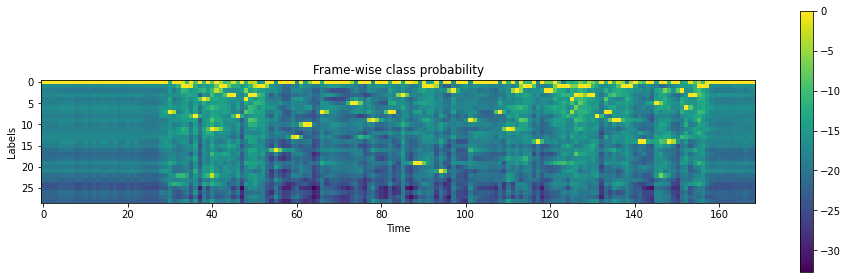

In [24]:
print(labels)
plt.imshow(emission.T)
plt.colorbar()
plt.title("Frame-wise class probability")
plt.xlabel("Time")
plt.ylabel("Labels")
plt.show()

In [25]:
transcript = 'I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT'
dictionary  = {c: i for i, c in enumerate(labels)}

tokens = [dictionary[c] for c in transcript]
print(list(zip(transcript, tokens)))

def get_trellis(emission, tokens, blank_id=0):
  num_frame = emission.size(0)
  num_tokens = len(tokens)

  # Trellis has extra diemsions for both time axis and tokens.
  # The extra dim for tokens represents <SoS> (start-of-sentence)
  # The extra dim for time axis is for simplification of the code.
  trellis = torch.full((num_frame+1, num_tokens+1), -float('inf'))
  trellis[:, 0] = 0
  for t in range(num_frame):
    trellis[t+1, 1:] = torch.maximum(
        # Score for staying at the same token
        trellis[t, 1:] + emission[t, blank_id],
        # Score for changing to the next token
        trellis[t, :-1] + emission[t, tokens],
    )
  return trellis

trellis = get_trellis(emission, tokens)

[('I', 7), ('|', 1), ('H', 8), ('A', 4), ('D', 11), ('|', 1), ('T', 3), ('H', 8), ('A', 4), ('T', 3), ('|', 1), ('C', 16), ('U', 13), ('R', 10), ('I', 7), ('O', 5), ('S', 9), ('I', 7), ('T', 3), ('Y', 19), ('|', 1), ('B', 21), ('E', 2), ('S', 9), ('I', 7), ('D', 11), ('E', 2), ('|', 1), ('M', 14), ('E', 2), ('|', 1), ('A', 4), ('T', 3), ('|', 1), ('T', 3), ('H', 8), ('I', 7), ('S', 9), ('|', 1), ('M', 14), ('O', 5), ('M', 14), ('E', 2), ('N', 6), ('T', 3)]


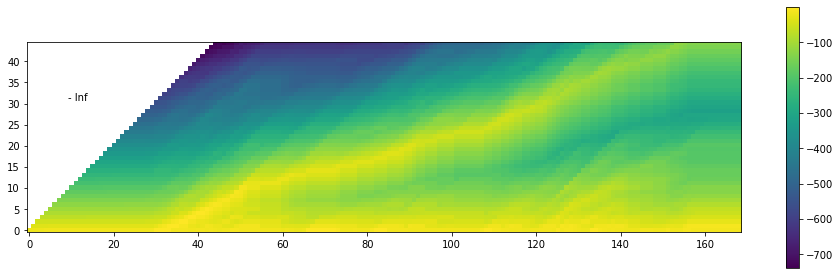

In [26]:
plt.imshow(trellis[1:, 1:].T, origin='lower')
plt.annotate("- Inf", (trellis.size(1) / 5, trellis.size(1) / 1.5))
plt.colorbar()
plt.show()

In [28]:
@dataclass
class Point:
  token_index: int
  time_index: int
  score: float


def backtrack(trellis, emission, tokens, blank_id=0):
  # Note:
  # j and t are indices for trellis, which has extra dimensions
  # for time and tokens at the beginning.
  # When refering to time frame index `T` in trellis,
  # the corresponding index in emission is `T-1`.
  # Similarly, when refering to token index `J` in trellis,
  # the corresponding index in transcript is `J-1`.
  j = trellis.size(1) - 1
  t_start = torch.argmax(trellis[:, j]).item()

  path = []
  for t in range(t_start, 0, -1):
    # 1. Figure out if the current position was stay or change
    # Note (again):
    # `emission[J-1]` is the emission at time frame `J` of trellis dimension.
    # Score for token staying the same from time frame J-1 to T.
    stayed = trellis[t-1, j] + emission[t-1, blank_id]
    # Score for token changing from C-1 at T-1 to J at T.
    changed = trellis[t-1, j-1] + emission[t-1, tokens[j-1]]

    # 2. Store the path with frame-wise probability.
    prob = emission[t-1, tokens[j-1] if changed > stayed else 0].exp().item()
    # Return token index and time index in non-trellis coordinate.
    path.append(Point(j-1, t-1, prob))

    # 3. Update the token
    if changed > stayed:
      j -= 1
      if j == 0:
        break
  else:
    raise ValueError('Failed to align')
  return path[::-1]

path = backtrack(trellis, emission, tokens)
print(path)

[Point(token_index=0, time_index=30, score=0.9999842643737793), Point(token_index=0, time_index=31, score=0.9847040176391602), Point(token_index=0, time_index=32, score=0.9999707937240601), Point(token_index=0, time_index=33, score=0.15398138761520386), Point(token_index=1, time_index=34, score=0.9999173879623413), Point(token_index=1, time_index=35, score=0.6080240607261658), Point(token_index=2, time_index=36, score=0.9997718930244446), Point(token_index=2, time_index=37, score=0.9997128844261169), Point(token_index=3, time_index=38, score=0.9999357461929321), Point(token_index=3, time_index=39, score=0.986155092716217), Point(token_index=4, time_index=40, score=0.9238618016242981), Point(token_index=4, time_index=41, score=0.9257345199584961), Point(token_index=4, time_index=42, score=0.015667563304305077), Point(token_index=5, time_index=43, score=0.9998378753662109), Point(token_index=6, time_index=44, score=0.9988441467285156), Point(token_index=6, time_index=45, score=0.10148232

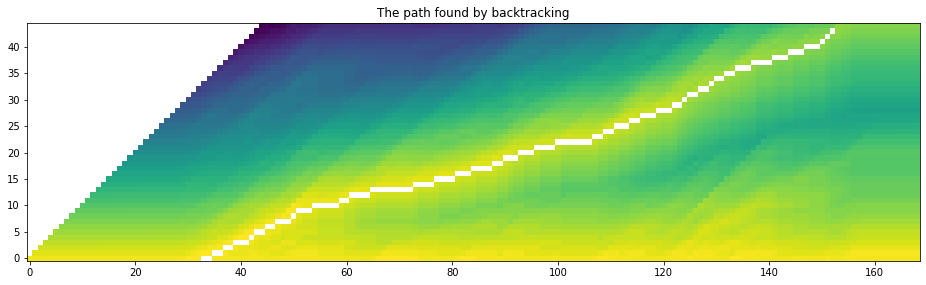

In [30]:
def plot_trellis_with_path(trellis, path):
    trellis_with_path = trellis.clone()
    for i, p in enumerate(path):
        trellis_with_path[p.time_index, p.token_index] = float('nan')
        
    plt.imshow(trellis_with_path[1:, 1:].T, origin="lower")
plot_trellis_with_path(trellis, path)
plt.title("The path found by backtracking")
plt.show()

In [31]:
# Merge the labels
@dataclass
class Segment:
  label: str
  start: int
  end: int
  score: float

  def __repr__(self):
    return f"{self.label}\t({self.score:4.2f}): [{self.start:5d}, {self.end:5d})"

  @property
  def length(self):
    return self.end - self.start

def merge_repeats(path):
  i1, i2 = 0, 0
  segments = []
  while i1 < len(path):
    while i2 < len(path) and path[i1].token_index == path[i2].token_index:
      i2 += 1
    score = sum(path[k].score for k in range(i1, i2)) / (i2 - i1)
    segments.append(Segment(transcript[path[i1].token_index], path[i1].time_index, path[i2-1].time_index + 1, score))
    i1 = i2
  return segments

segments = merge_repeats(path)
for seg in segments:
  print(seg)

I	(0.78): [   30,    34)
|	(0.80): [   34,    36)
H	(1.00): [   36,    38)
A	(0.99): [   38,    40)
D	(0.62): [   40,    43)
|	(1.00): [   43,    44)
T	(0.55): [   44,    46)
H	(1.00): [   46,    48)
A	(0.37): [   48,    51)
T	(0.00): [   51,    52)
|	(1.00): [   52,    55)
C	(0.97): [   55,    60)
U	(1.00): [   60,    62)
R	(0.75): [   62,    66)
I	(0.88): [   66,    74)
O	(0.99): [   74,    78)
S	(1.00): [   78,    82)
I	(0.89): [   82,    85)
T	(0.78): [   85,    89)
Y	(0.70): [   89,    91)
|	(0.66): [   91,    94)
B	(1.00): [   94,    97)
E	(1.00): [   97,   101)
S	(1.00): [  101,   108)
I	(1.00): [  108,   110)
D	(0.93): [  110,   112)
E	(0.66): [  112,   115)
|	(1.00): [  115,   117)
M	(0.67): [  117,   120)
E	(0.67): [  120,   123)
|	(0.50): [  123,   125)
A	(0.98): [  125,   126)
T	(0.50): [  126,   128)
|	(0.51): [  128,   130)
T	(1.00): [  130,   131)
H	(1.00): [  131,   133)
I	(0.75): [  133,   135)
S	(0.36): [  135,   138)
|	(0.50): [  138,   142)
M	(1.00): [  142,   145)


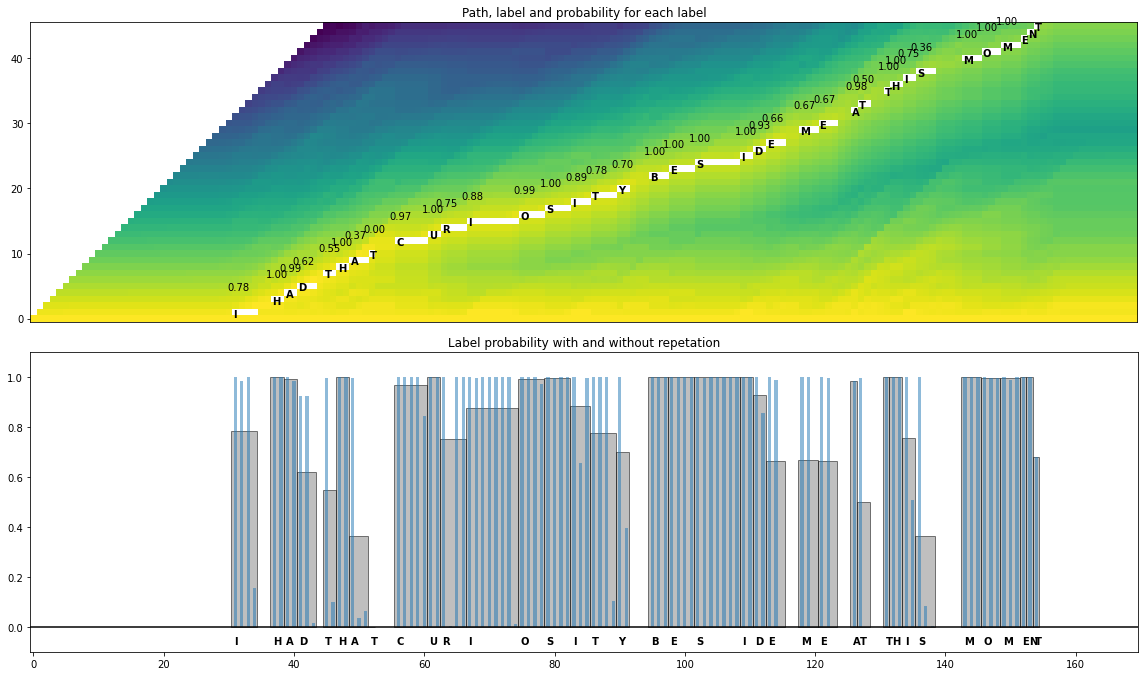

In [32]:
def plot_trellis_with_segments(trellis, segments, transcript):
  # To plot trellis with path, we take advantage of 'nan' value
  trellis_with_path = trellis.clone()
  for i, seg in enumerate(segments):
    if seg.label != '|':
      trellis_with_path[seg.start+1:seg.end+1, i+1] = float('nan')

  fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))
  ax1.set_title("Path, label and probability for each label")
  ax1.imshow(trellis_with_path.T, origin='lower')
  ax1.set_xticks([])

  for i, seg in enumerate(segments):
    if seg.label != '|':
      ax1.annotate(seg.label, (seg.start + .7, i + 0.3), weight='bold')
      ax1.annotate(f'{seg.score:.2f}', (seg.start - .3, i + 4.3))

  ax2.set_title("Label probability with and without repetation")
  xs, hs, ws = [], [], []
  for seg in segments:
    if seg.label != '|':
      xs.append((seg.end + seg.start) / 2 + .4)
      hs.append(seg.score)
      ws.append(seg.end - seg.start)
      ax2.annotate(seg.label, (seg.start + .8, -0.07), weight='bold')
  ax2.bar(xs, hs, width=ws, color='gray', alpha=0.5, edgecolor='black')

  xs, hs = [], []
  for p in path:
    label = transcript[p.token_index]
    if label != '|':
      xs.append(p.time_index + 1)
      hs.append(p.score)

  ax2.bar(xs, hs, width=0.5, alpha=0.5)
  ax2.axhline(0, color='black')
  ax2.set_xlim(ax1.get_xlim())
  ax2.set_ylim(-0.1, 1.1)

plot_trellis_with_segments(trellis, segments, transcript)
plt.tight_layout()
plt.show()

In [33]:
# Merge words
def merge_words(segments, separator='|'):
  words = []
  i1, i2 = 0, 0
  while i1 < len(segments):
    if i2 >= len(segments) or segments[i2].label == separator:
      if i1 != i2:
        segs = segments[i1:i2]
        word = ''.join([seg.label for seg in segs])
        score = sum(seg.score * seg.length for seg in segs) / sum(seg.length for seg in segs)
        words.append(Segment(word, segments[i1].start, segments[i2-1].end, score))
      i1 = i2 + 1
      i2 = i1
    else:
      i2 += 1
  return words

word_segments = merge_words(segments)
for word in word_segments:
  print(word)

I	(0.78): [   30,    34)
HAD	(0.84): [   36,    43)
THAT	(0.52): [   44,    52)
CURIOSITY	(0.89): [   55,    91)
BESIDE	(0.94): [   94,   115)
ME	(0.67): [  117,   123)
AT	(0.66): [  125,   128)
THIS	(0.70): [  130,   138)
MOMENT	(0.97): [  142,   154)


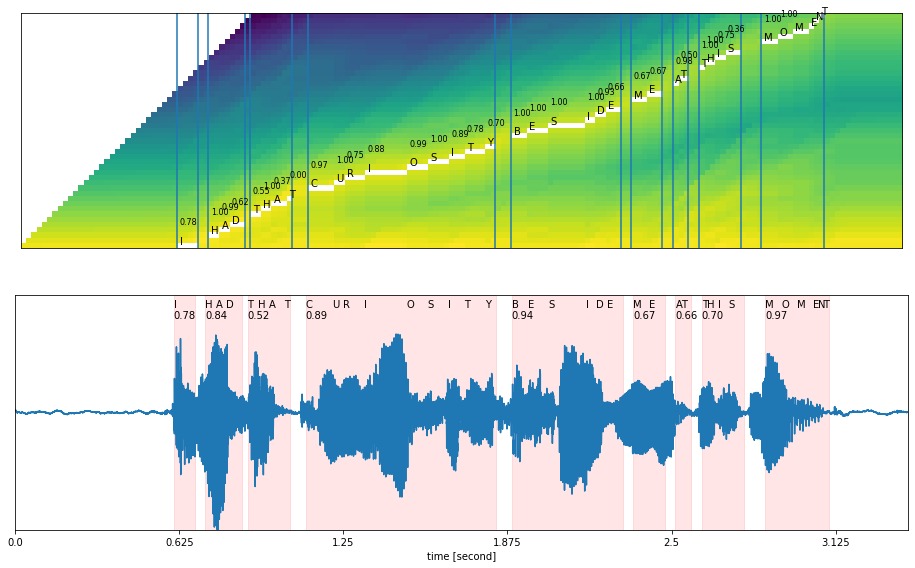

In [34]:
def plot_alignments(trellis, segments, word_segments, waveform):
  trellis_with_path = trellis.clone()
  for i, seg in enumerate(segments):
    if seg.label != '|':
      trellis_with_path[seg.start+1:seg.end+1, i+1] = float('nan')

  fig, [ax1, ax2] = plt.subplots(2, 1, figsize=(16, 9.5))

  ax1.imshow(trellis_with_path[1:, 1:].T, origin='lower')
  ax1.set_xticks([])
  ax1.set_yticks([])

  for word in word_segments:
    ax1.axvline(word.start - 0.5)
    ax1.axvline(word.end - 0.5)

  for i, seg in enumerate(segments):
    if seg.label != '|':
      ax1.annotate(seg.label, (seg.start, i + 0.3))
      ax1.annotate(f'{seg.score:.2f}', (seg.start , i + 4), fontsize=8)

  # The original waveform
  ratio = waveform.size(0) / (trellis.size(0) - 1)
  ax2.plot(waveform)
  for word in word_segments:
    x0 = ratio * word.start
    x1 = ratio * word.end
    ax2.axvspan(x0, x1, alpha=0.1, color='red')
    ax2.annotate(f'{word.score:.2f}', (x0, 0.8))

  for seg in segments:
    if seg.label != '|':
      ax2.annotate(seg.label, (seg.start * ratio, 0.9))
  xticks = ax2.get_xticks()
  plt.xticks(xticks, xticks / bundle.sample_rate)
  ax2.set_xlabel('time [second]')
  ax2.set_yticks([])
  ax2.set_ylim(-1.0, 1.0)
  ax2.set_xlim(0, waveform.size(-1))

plot_alignments(trellis, segments, word_segments, waveform[0],)
plt.show()

# A trick to embed the resulting audio to the generated file.
# `IPython.display.Audio` has to be the last call in a cell,
# and there should be only one call par cell.
def display_segment(i):
  ratio = waveform.size(1) / (trellis.size(0) - 1)
  word = word_segments[i]
  x0 = int(ratio * word.start)
  x1 = int(ratio * word.end)
  filename = f"_assets/{i}_{word.label}.wav"
  torchaudio.save(filename, waveform[:, x0:x1], bundle.sample_rate)
  print(f"{word.label} ({word.score:.2f}): {x0 / bundle.sample_rate:.3f} - {x1 / bundle.sample_rate:.3f} sec")
  return IPython.display.Audio(filename)

In [35]:
# Generate the audio for each segment
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT


In [36]:
display_segment(0)

I (0.78): 0.604 - 0.684 sec


In [37]:
display_segment(1)

HAD (0.84): 0.724 - 0.865 sec


In [38]:
display_segment(2)

THAT (0.52): 0.885 - 1.046 sec


In [39]:
display_segment(3)

CURIOSITY (0.89): 1.107 - 1.831 sec


In [40]:
display_segment(4)

BESIDE (0.94): 1.891 - 2.314 sec


In [41]:
display_segment(5)

ME (0.67): 2.354 - 2.474 sec


In [42]:
display_segment(6)

AT (0.66): 2.515 - 2.575 sec


In [43]:
display_segment(7)

THIS (0.70): 2.615 - 2.776 sec


In [44]:
display_segment(8)

MOMENT (0.97): 2.857 - 3.098 sec


# Language modeling with nn.Transformer and torchtext

In [1]:
import math
from typing import Tuple
import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class TransformerModel(nn.Module):
    def __init__(self, ntoken:int, d_model:int, nhead:int, d_hid:int, nlayers:int, dropout:float=0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)
        self.init_weights
    def init_weights(self)->None:
        initrange = 0.1
        self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)
    def forward(self, src:Tensor, src_mask:Tensor) -> Tensor:
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = self.decoder(output)
        return output
def generate_square_subsequent_mask(sz: int)->Tensor:
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

In [2]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [3]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
import torchtext
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

# train_iter was "consumed" by the process of building the vocab,
# so we have to create it again
train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data: Tensor, bsz: int) -> Tensor:
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  # shape [seq_len, batch_size]
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

In [4]:
bptt = 35
def get_batch(source: Tensor, i: int)->Tuple[Tensor, Tensor]:
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i +seq_len]
    target = source[i + 1: i + 1 + seq_len].reshape(-1)
    return data, target

In [5]:
ntokens = len(vocab)
emsize = 200
d_hid = 200
nlayers = 2
nhead = 2
dropout = 0.2
model = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout).to(device)

In [6]:
import copy
import time

criterion = nn.CrossEntropyLoss()
lr = 5.0  # learning rate
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)

def train(model: nn.Module) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 200
    start_time = time.time()
    src_mask = generate_square_subsequent_mask(bptt).to(device)

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        batch_size = data.size(0)
        if batch_size != bptt:  # only on last batch
            src_mask = src_mask[:batch_size, :batch_size]
        output = model(data, src_mask)
        loss = criterion(output.view(-1, ntokens), targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {batch:5d}/{num_batches:5d} batches | '
                  f'lr {lr:02.2f} | ms/batch {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.2f} | ppl {ppl:8.2f}')
            total_loss = 0
            start_time = time.time()

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    src_mask = generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            data, targets = get_batch(eval_data, i)
            batch_size = data.size(0)
            if batch_size != bptt:
                src_mask = src_mask[:batch_size, :batch_size]
            output = model(data, src_mask)
            output_flat = output.view(-1, ntokens)
            total_loss += batch_size * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

In [7]:
best_val_loss = float('inf')
epochs = 3
best_model = None
for epoch in range(1, epochs + 1):
    epoch_start_time = time.time()
    train(model)
    val_loss = evaluate(model, val_data)
    val_ppl = math.exp(val_loss)
    elapsed = time.time() - epoch_start_time
    print('-'*89)
    print(f"| end of epoch {epoch:3d} | time: {elapsed:8.2f}s"
         f"valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}")
    print("-"*89)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
    scheduler.step()

| epoch   1 |   200/ 2928 batches | lr 5.00 | ms/batch 859.79 | loss  7.56 | ppl  1928.60
| epoch   1 |   400/ 2928 batches | lr 5.00 | ms/batch 849.76 | loss  6.91 | ppl  1003.97
| epoch   1 |   600/ 2928 batches | lr 5.00 | ms/batch 856.99 | loss  6.62 | ppl   748.38
| epoch   1 |   800/ 2928 batches | lr 5.00 | ms/batch 831.77 | loss  6.51 | ppl   669.73
| epoch   1 |  1000/ 2928 batches | lr 5.00 | ms/batch 821.28 | loss  6.43 | ppl   619.02
| epoch   1 |  1200/ 2928 batches | lr 5.00 | ms/batch 833.24 | loss  6.42 | ppl   613.46
| epoch   1 |  1400/ 2928 batches | lr 5.00 | ms/batch 837.74 | loss  6.35 | ppl   570.73
| epoch   1 |  1600/ 2928 batches | lr 5.00 | ms/batch 829.77 | loss  6.37 | ppl   583.85
| epoch   1 |  1800/ 2928 batches | lr 5.00 | ms/batch 822.48 | loss  6.28 | ppl   534.24
| epoch   1 |  2000/ 2928 batches | lr 5.00 | ms/batch 834.09 | loss  6.28 | ppl   533.25
| epoch   1 |  2200/ 2928 batches | lr 5.00 | ms/batch 835.17 | loss  6.18 | ppl   482.59
| epoch   

In [8]:
test_loss = evaluate(best_model, test_data)
test_ppl = math.exp(test_loss)
print("="*89)
print(f'|End of training | test loss {test_loss:5.2f}| test ppl {test_ppl:8.2f}')
print("="*89)

|End of training | test loss  5.79| test ppl   327.08


# NLP from scratch

In [11]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path):
    return glob.glob(path)

print(findFiles('D:/datasets_CSV/data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + ".,;'"
n_letters = len(all_letters)

def unicodeToAscii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != "Mn" and
                   c in all_letters)

category_lines = {}
all_categories = []

def readLines(filename):
    lines = open(filename, encoding="utf-8").read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles("D:/datasets_CSV/data/names/*.txt"):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines
n_categories = len(all_categories)

['D:/datasets_CSV/data/names\\Arabic.txt', 'D:/datasets_CSV/data/names\\Chinese.txt', 'D:/datasets_CSV/data/names\\Czech.txt', 'D:/datasets_CSV/data/names\\Dutch.txt', 'D:/datasets_CSV/data/names\\English.txt', 'D:/datasets_CSV/data/names\\French.txt', 'D:/datasets_CSV/data/names\\German.txt', 'D:/datasets_CSV/data/names\\Greek.txt', 'D:/datasets_CSV/data/names\\Irish.txt', 'D:/datasets_CSV/data/names\\Italian.txt', 'D:/datasets_CSV/data/names\\Japanese.txt', 'D:/datasets_CSV/data/names\\Korean.txt', 'D:/datasets_CSV/data/names\\Polish.txt', 'D:/datasets_CSV/data/names\\Portuguese.txt', 'D:/datasets_CSV/data/names\\Russian.txt', 'D:/datasets_CSV/data/names\\Scottish.txt', 'D:/datasets_CSV/data/names\\Spanish.txt', 'D:/datasets_CSV/data/names\\Vietnamese.txt']


In [12]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


In [13]:
import torch

def letterToIndex(letter):
    return all_letters.find(letter)

def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor
print(letterToTensor('J'))
print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0.]])
torch.Size([5, 1, 56])


In [25]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [26]:
input = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input, hidden)

In [27]:
input = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

output, next_hidden = rnn(input[0], hidden)
print(output)

tensor([[-2.8984, -2.9305, -2.8421, -2.7862, -2.8991, -2.9348, -2.8814, -2.8995,
         -2.9583, -2.9576, -2.8171, -2.8964, -2.9157, -2.9308, -2.9044, -2.8467,
         -2.8181, -2.9314]], grad_fn=<LogSoftmaxBackward0>)


In [28]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i
print(categoryFromOutput(output))

('Dutch', 3)


In [29]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category = ', category, '/ line = ', line)

category =  Italian / line =  Dicaprio
category =  Russian / line =  Verbenko
category =  Greek / line =  Katsourinis
category =  Scottish / line =  Watt
category =  Chinese / line =  Shi
category =  Polish / line =  Szewc
category =  Spanish / line =  Fernandez
category =  English / line =  Tufnall
category =  Vietnamese / line =  Quyen
category =  Japanese / line =  Ouchi


In [30]:
criterion = nn.NLLLoss()

In [35]:
learning_rate = 0.005

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()
    rnn.zero_grad()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    loss = criterion(output, category_tensor)
    loss.backward()
        
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)
    return output, loss.item()

In [36]:
import time
import math

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds'%(m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = 'right' if guess == category else 'worng (%s)'%category
        print('%d %d%% (%s) %.4f %s / %s %s'%(iter, iter / n_iters * 100, timeSince(start), loss, line, guess, 
                                              correct))
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 14s) 2.7103 Matos / Greek worng (Portuguese)
10000 10% (0m 28s) 2.3750 Lachapelle / Russian worng (French)
15000 15% (0m 42s) 0.4766 Filipowski / Polish right
20000 20% (0m 56s) 2.6750 Aodh / Vietnamese worng (Irish)
25000 25% (1m 10s) 1.9445 Costa / Czech worng (Spanish)
30000 30% (1m 24s) 0.1258 Garofalis / Greek right
35000 35% (1m 37s) 1.3216 Belanger / French right
40000 40% (1m 52s) 2.3423 Berger / German worng (French)
45000 45% (2m 6s) 1.5668 Nitta / Japanese right
50000 50% (2m 20s) 1.1758 Souza / Portuguese right
55000 55% (2m 35s) 4.2305 Gwock / Polish worng (Chinese)
60000 60% (2m 49s) 0.0987 Williamson / Scottish right
65000 65% (3m 2s) 2.3429 Meindl / Irish worng (German)
70000 70% (3m 16s) 0.2073 O'Hare / Irish right
75000 75% (3m 30s) 0.3424 Sauvageau / French right
80000 80% (3m 44s) 3.9354 Colling / Irish worng (Czech)
85000 85% (3m 59s) 0.4092 Escarcega / Spanish right
90000 90% (4m 13s) 0.7121 Chavarria / Spanish right
95000 95% (4m 27s) 0.1291 Andrysiak

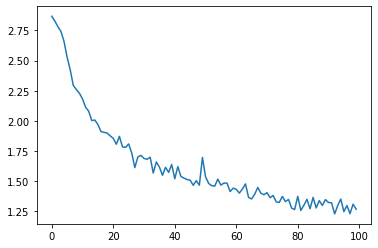

In [37]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

<ipython-input-41-89b2e1216416>:25: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + all_categories, rotation=90)
<ipython-input-41-89b2e1216416>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + all_categories)


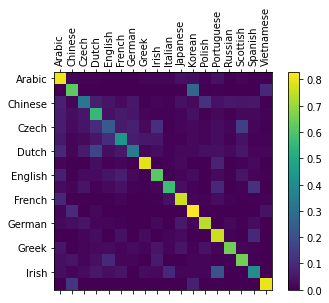

In [41]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.initHidden()
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
    
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [43]:
def predict(input_line, n_predictions = 3):
    print('\n> %s'%input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))
        
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []
        
        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            
            print('(%.2f) %s'%(value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])
predict('Dovesky')
predict('Jackson')
predict('Satoshi')


> Dovesky
(-0.76) Russian
(-0.87) Czech
(-2.85) Polish

> Jackson
(-0.13) Scottish
(-2.81) English
(-3.45) Russian

> Satoshi
(-1.32) Arabic
(-1.41) Japanese
(-1.59) Italian


# Generating Names

In [44]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    with open(filename, encoding='utf-8') as some_file:
        return [unicodeToAscii(line.strip()) for line in some_file]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('D:/datasets_CSV/data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


In [45]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [46]:
import random
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [47]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [54]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [55]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        l = criterion(output, target_line_tensor[i])
        loss += l

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)

In [56]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds'%(m, s)

In [57]:
rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 33s (5000 5%) 3.1399
1m 5s (10000 10%) 2.8269
1m 38s (15000 15%) 2.7693
2m 10s (20000 20%) 2.6576
2m 42s (25000 25%) 2.3170
3m 16s (30000 30%) 1.4856
3m 49s (35000 35%) 1.2375
4m 21s (40000 40%) 2.0580
4m 54s (45000 45%) 2.1568
5m 26s (50000 50%) 2.0605
5m 59s (55000 55%) 2.6199
6m 31s (60000 60%) 2.2820
7m 4s (65000 65%) 2.0257
7m 37s (70000 70%) 1.8240
8m 9s (75000 75%) 2.2076
8m 41s (80000 80%) 2.7023
9m 13s (85000 85%) 2.2864
9m 46s (90000 90%) 2.7661
10m 19s (95000 95%) 2.6309
10m 51s (100000 100%) 2.9663


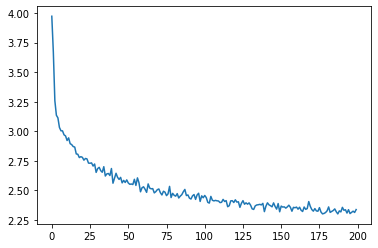

In [58]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(all_losses)

In [59]:
max_length = 20

# Sample from a category and starting letter
def sample(category, start_letter='A'):
    with torch.no_grad():  # no need to track history in sampling
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(category_tensor, input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(category, start_letters='ABC'):
    for start_letter in start_letters:
        print(sample(category, start_letter))

samples('Russian', 'RUS')

samples('German', 'GER')

samples('Spanish', 'SPA')

samples('Chinese', 'CHI')

Rovakov
Uanton
Santonov
Gerten
Eerter
Rouren
Santa
Paro
Allan
Cha
Ha
Iun


# NPL from scratch

In [86]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import time
import math

In [87]:
SOS_token = 0
EOS_token = 1


class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [88]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [89]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('D:/datasets_CSV/data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [90]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)


def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [91]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...
Read 135842 sentence pairs
Trimmed to 10599 sentence pairs
Counting words...
Counted words:
fra 4345
eng 2803
['je suis disposee a me repentir .', 'i m ready to make amends .']


In [92]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        
    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [93]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, output_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, input, hidden):
        output = self.embbeding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    

In [94]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p = 0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [95]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [96]:
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [97]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds'%(m, s)
def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)'%(asMinutes(s), asMinutes(rs))

In [98]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [99]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocater(base=0.2)
    ax.yaxis.set_major_locater(loc)
    plt.plot(points)

In [100]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [101]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attention = evaluate(encoder, decoder, pair[0])
        output_sentence = ''.join(output_words)
        print('<', output_sentence)
        print('')

In [102]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

7m 18s (- 102m 19s) (5000 6%) 2.9077
14m 38s (- 95m 9s) (10000 13%) 2.2816
22m 4s (- 88m 18s) (15000 20%) 1.9966
29m 35s (- 81m 23s) (20000 26%) 1.7377
37m 3s (- 74m 7s) (25000 33%) 1.5164
45m 9s (- 67m 43s) (30000 40%) 1.3509
52m 36s (- 60m 7s) (35000 46%) 1.2115
60m 1s (- 52m 31s) (40000 53%) 1.0890
67m 32s (- 45m 1s) (45000 60%) 0.9661
75m 4s (- 37m 32s) (50000 66%) 0.9032
82m 37s (- 30m 2s) (55000 73%) 0.8045
90m 21s (- 22m 35s) (60000 80%) 0.7474
97m 57s (- 15m 4s) (65000 86%) 0.6664
105m 26s (- 7m 31s) (70000 93%) 0.5974
112m 59s (- 0m 0s) (75000 100%) 0.5770


AttributeError: module 'matplotlib.ticker' has no attribute 'MultipleLocater'

In [103]:
evaluateRandomly(encoder1, attn_decoder1)

> je crains que tu te perdes .
= i am afraid that you will get lost .
< iamafraidyouwillgetlost.<EOS>

> ils mentent .
= they re lying .
< theyrecoming.<EOS>

> tu penses de travers .
= you re not thinking straight .
< yourenotthinking.<EOS>

> je suis etonne par ton attitude irresponsable .
= i am alarmed by your irresponsible attitude .
< iamalarmedbyyourirresponsibleattitude.<EOS>

> elles sont cousines .
= they re cousins .
< theyrecareful.<EOS>

> il est tres sceptique .
= he s very skeptical .
< hesveryskeptical.<EOS>

> il ne voit pas d un il .
= he is blind in one eye .
< hesnotmakingajob.<EOS>

> nous sommes vraiment bonnes .
= we re really good .
< werereallygood.<EOS>

> nous sommes a la fac .
= we re in college .
< wereincollegecollege.<EOS>

> nous sommes sous son commandement .
= we are under his command .
< weareunderhiscommand.<EOS>



In [107]:
import matplotlib.pyplot as plt
output_words, attentions = evaluate(encoder1, attn_decoder1, "je suis trop froid .")
plt.matshow(attentions.numpy())
plt.show()

<ipython-input-107-27607ea98072>:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


In [108]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)


evaluateAndShowAttention("elle a cinq ans de moins que moi .")

evaluateAndShowAttention("elle est trop petit .")

evaluateAndShowAttention("je ne crains pas de mourir .")

evaluateAndShowAttention("c est un jeune directeur plein de talent .")

input = elle a cinq ans de moins que moi .
output = she s five years younger than me . <EOS>
input = elle est trop petit .
output = she s too drunk . <EOS>


<ipython-input-108-9b51ff8fc28e>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + input_sentence.split(' ') +
<ipython-input-108-9b51ff8fc28e>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + output_words)
<ipython-input-108-9b51ff8fc28e>:17: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


input = je ne crains pas de mourir .
output = i m not scared of dying . <EOS>
input = c est un jeune directeur plein de talent .
output = he s a talented young . . <EOS>


# Text classification with torchtext library

In [109]:
import torch
from torchtext.datasets import AG_NEWS
train_iter = iter(AG_NEWS(split="train"))

In [110]:
next(train_iter)

(3,
 "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.")

In [111]:
next(train_iter)

(3,
 'Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.')

In [112]:
next(train_iter)

(3,
 "Oil and Economy Cloud Stocks' Outlook (Reuters) Reuters - Soaring crude prices plus worries\\about the economy and the outlook for earnings are expected to\\hang over the stock market next week during the depth of the\\summer doldrums.")

In [113]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('basic_english')
train_iter = AG_NEWS(split='train')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [114]:
vocab(['here', 'is', "an", "example"])

[475, 21, 30, 5297]

In [115]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x) - 1

In [116]:
text_pipeline('here is an example')

[475, 21, 30, 5297]

In [117]:
label_pipeline('10')

9

In [124]:
from torch.utils.data import DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

train_iter = AG_NEWS(split="train")
dataloader = DataLoader(train_iter, batch_size=8, shuffle=False, collate_fn=collate_batch)

In [125]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()
    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [126]:
train_iter = AG_NEWS(split="train")
num_classes = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_classes).to(device)

In [127]:
import time

def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

In [128]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
# Hyperparameters
EPOCHS = 10 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
total_accu = None
train_iter, test_iter = AG_NEWS()
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.95)
split_train_, split_valid_ = \
    random_split(train_dataset, [num_train, len(train_dataset) - num_train])

train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                             shuffle=True, collate_fn=collate_batch)

for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   500/ 1782 batches | accuracy    0.674
| epoch   1 |  1000/ 1782 batches | accuracy    0.853
| epoch   1 |  1500/ 1782 batches | accuracy    0.875
-----------------------------------------------------------
| end of epoch   1 | time: 34.37s | valid accuracy    0.885 
-----------------------------------------------------------
| epoch   2 |   500/ 1782 batches | accuracy    0.898
| epoch   2 |  1000/ 1782 batches | accuracy    0.896
| epoch   2 |  1500/ 1782 batches | accuracy    0.903
-----------------------------------------------------------
| end of epoch   2 | time: 34.98s | valid accuracy    0.894 
-----------------------------------------------------------
| epoch   3 |   500/ 1782 batches | accuracy    0.916
| epoch   3 |  1000/ 1782 batches | accuracy    0.912
| epoch   3 |  1500/ 1782 batches | accuracy    0.914
-----------------------------------------------------------
| end of epoch   3 | time: 33.71s | valid accuracy    0.880 
-------------------------------

In [130]:
print("Checking the results of test dataset.")
accu_test = evaluate(test_dataloader)
print('test accuracy {:8.3f}'.format(accu_test))

Checking the results of test dataset.
test accuracy    0.905


In [131]:
ag_news_label = {1: "World",
                 2: "Sports",
                 3: "Business",
                 4: "Sci/Tec"}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item() + 1

ex_text_str = "MEMPHIS, Tenn. – Four days ago, Jon Rahm was \
    enduring the season’s worst weather conditions on Sunday at The \
    Open on his way to a closing 75 at Royal Portrush, which \
    considering the wind and the rain was a respectable showing. \
    Thursday’s first round at the WGC-FedEx St. Jude Invitational \
    was another story. With temperatures in the mid-80s and hardly any \
    wind, the Spaniard was 13 strokes better in a flawless round. \
    Thanks to his best putting performance on the PGA Tour, Rahm \
    finished with an 8-under 62 for a three-stroke lead, which \
    was even more impressive considering he’d never played the \
    front nine at TPC Southwind."

model = model.to("cpu")

print("This is a %s news" %ag_news_label[predict(ex_text_str, text_pipeline)])

This is a Sports news
